In [0]:
!git clone -b dev https://github.com/nyikovicsmate/thesis

Cloning into 'thesis'...
remote: Enumerating objects: 148, done.
remote: Counting objects: 100% (148/148), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 1567 (delta 98), reused 111 (delta 72), pack-reused 1419
Receiving objects: 100% (1567/1567), 163.36 MiB | 35.73 MiB/s, done.
Resolving deltas: 100% (587/587), done.


In [0]:
%cd thesis

/content/thesis


In [0]:
!pip3 install -q gdown
# bsd500_gray.zip
!gdown https://drive.google.com/uc?id=1O2tduoLX1DdP3VoLkAQfuv5ssFxf8LPc
!unzip -q bsd500_gray.zip
# # bsd500_color.zip
!gdown https://drive.google.com/uc?id=1buG1ziqMjy18gnpkuQjqk81XrLsGjT7p
!unzip -q bsd500_color.zip
# # set14_color.zip
!gdown https://drive.google.com/uc?id=1OiDs7jRm3NZCY6ghjyE12G5hVS0fG4EM
!unzip -q set14_color.zip

Downloading...
From: https://drive.google.com/uc?id=1O2tduoLX1DdP3VoLkAQfuv5ssFxf8LPc
To: /content/thesis/bsd500_gray.zip
11.3MB [00:00, 52.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1buG1ziqMjy18gnpkuQjqk81XrLsGjT7p
To: /content/thesis/bsd500_color.zip
29.4MB [00:00, 80.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1OiDs7jRm3NZCY6ghjyE12G5hVS0fG4EM
To: /content/thesis/set14_color.zip
100% 831k/831k [00:00<00:00, 55.7MB/s]


In [0]:
%tensorflow_version 2.x
from src.networks.supervised.post_upsampling_network import PostUpsamplingNetwork
from src.callbacks import *
from src.dataset import *
import numpy as np
import tensorflow as tf

In [0]:
batch_size = 20
seed = 1111
epochs = 5000
learning_rate = 1e-6

normalize = lambda x: np.array(x / 255.0, dtype=np.float32)
downsample = lambda x: np.array([cv2.resize(x_i, (x.shape[2]//2, x.shape[1]//2), interpolation=cv2.INTER_CUBIC) for x_i in x])
ds_hr = HDFDataset("bsd500_70_70_color.h5")\
    .batch(batch_size)\
    .shuffle(seed=seed)\
    .map(normalize)\
    .transform()
ds_lr = HDFDataset("bsd500_70_70_color.h5")\
    .batch(batch_size)\
    .shuffle(seed=seed)\
    .map(downsample)\
    .map(normalize)\
    .transform()

input_shape = (None, None, 3)
loss_func = tf.keras.losses.mse
cb = [TrainingCheckpointCallback(appendix="_color", save_freq=20),
       ExponentialDecayCallback(learning_rate, epochs/5, decay_rate=0.5)]

In [0]:
network = PostUpsamplingNetwork(input_shape=input_shape)
network.train(ds_lr, ds_hr, loss_func, epochs, learning_rate, cb)

Streaming output truncated to the last 5000 lines.
[2020-05-20 13:01:57,841] INFO _train(): Epoch: 425 train_loss: 63190.92
[2020-05-20 13:01:58,167] INFO _train(): Epoch: 426 train_loss: 62963.34
[2020-05-20 13:01:58,489] INFO _train(): Epoch: 427 train_loss: 62807.54
[2020-05-20 13:01:58,810] INFO _train(): Epoch: 428 train_loss: 62618.79
[2020-05-20 13:01:59,133] INFO _train(): Epoch: 429 train_loss: 62391.78
[2020-05-20 13:01:59,454] INFO _train(): Epoch: 430 train_loss: 62180.59
[2020-05-20 13:01:59,780] INFO _train(): Epoch: 431 train_loss: 62229.59
[2020-05-20 13:02:00,105] INFO _train(): Epoch: 432 train_loss: 61967.02
[2020-05-20 13:02:00,433] INFO _train(): Epoch: 433 train_loss: 61768.75
[2020-05-20 13:02:00,756] INFO _train(): Epoch: 434 train_loss: 61802.00
[2020-05-20 13:02:01,080] INFO _train(): Epoch: 435 train_loss: 61376.91
[2020-05-20 13:02:01,408] INFO _train(): Epoch: 436 train_loss: 61260.39
[2020-05-20 13:02:01,730] INFO _train(): Epoch: 437 train_loss: 61389.53


[2020-05-20 13:26:42,266] INFO load_state(): Loaded state with: 
Train time: 00h:25m:53s
Epochs:     4980
Loss:       20389.0723
[2020-05-20 13:26:42,414] INFO _predict(): Predicted images with shape: (14, 70, 70, 3)
   HR   ALIASED   NETWORK   


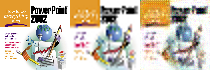

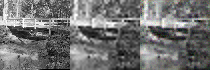

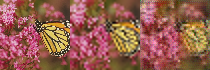

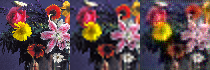

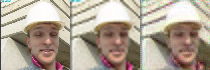

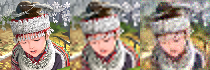

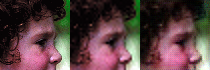

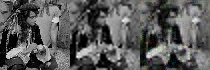

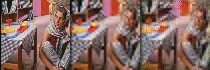

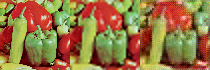

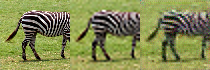

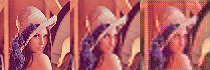

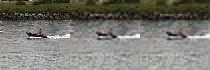

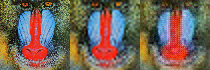

SSIM
max: [4] 0.79    min: [13] 0.45    avg: 0.60
TOTAL_VARIATION
max: [0] 2453.63    min: [12] 1091.65    avg: 1859.54
PSNR
max: [6] 24.87    min: [0] 15.05    avg: 19.21
MEAN_SQUARED_ERROR
max: [0] 153.14    min: [6] 15.97    avg: 68.00
MEAN_ABSOLUTE_ERROR
max: [0] 565.20    min: [6] 199.04    avg: 400.03


In [0]:
from google.colab.patches import cv2_imshow

ds_ev_lr = DirectoryDataset("set14_70_70_color")\
    .map(downsample)\
    .map(normalize)
ds_ev_hr = DirectoryDataset("set14_70_70_color")\
    .map(normalize)

# load best network state
network.load_state("_color")

with ds_ev_lr as x, ds_ev_hr as y:
    x_batch = next(iter(x))
    y_batch = next(iter(y))
    # predict
    y_pred = network.predict(x_batch)
    print("   HR   ALIASED   NETWORK   ")
    for image_idx in range(len(x_batch)):
        aliased = tf.image.resize(x_batch[image_idx], size=tuple(y_batch[image_idx].shape[:2]), method="bicubic", antialias=True)
        img_0 = np.concatenate((y_batch[image_idx], aliased, y_pred[image_idx]), axis=1)
        cv2_imshow(img_0*255)
    # evaluate
    results = network.evaluate(y_batch, y_pred)

[2020-05-20 13:26:42,908] INFO _predict(): Predicted images with shape: (10, 70, 70, 3)
   HR   ALIASED   NETWORK   


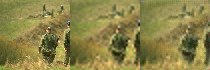

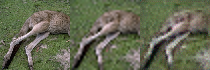

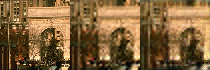

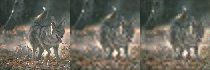

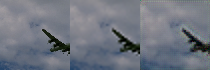

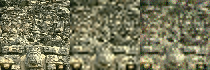

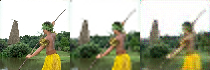

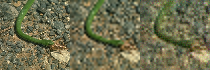

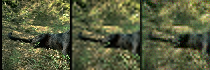

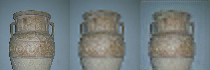

SSIM
max: [4] 0.89    min: [5] 0.50    avg: 0.64
TOTAL_VARIATION
max: [5] 2355.85    min: [4] 622.59    avg: 1347.19
PSNR
max: [4] 29.76    min: [5] 15.75    avg: 22.33
MEAN_SQUARED_ERROR
max: [5] 130.30    min: [4] 5.17    avg: 41.66
MEAN_ABSOLUTE_ERROR
max: [5] 628.04    min: [4] 86.51    avg: 300.75


In [0]:
# PREDICT WITH THE TRAINING DATASET

ds = HDFDataset("bsd500_70_70_color.h5").batch(10)
ds_hr = ds.map(normalize)
ds_lr = ds.map(downsample).map(normalize)

with ds_lr as x, ds_hr as y:
    x_batch = next(iter(x))
    y_batch = next(iter(y))
    # predict
    y_pred = network.predict(x_batch)
    print("   HR   ALIASED   NETWORK   ")
    for image_idx in range(len(x_batch)):
        aliased = tf.image.resize(x_batch[image_idx], size=tuple(y_batch[image_idx].shape[:2]), method="bicubic", antialias=True)
        img_0 = np.concatenate((y_batch[image_idx], aliased, y_pred[image_idx]), axis=1)
        cv2_imshow(img_0*255)
    # evaluate
    results = network.evaluate(y_batch, y_pred)

In [0]:
!zip -r ./postupsamplingnetwork_color.zip ./checkpoints/postupsamplingnetwork_color

  adding: checkpoints/postupsamplingnetwork_color/ (stored 0%)
  adding: checkpoints/postupsamplingnetwork_color/checkpoint (deflated 37%)
  adding: checkpoints/postupsamplingnetwork_color/weights.data-00000-of-00002 (deflated 79%)
  adding: checkpoints/postupsamplingnetwork_color/weights.data-00001-of-00002 (deflated 8%)
  adding: checkpoints/postupsamplingnetwork_color/weights.index (deflated 65%)
  adding: checkpoints/postupsamplingnetwork_color/state.dat (deflated 15%)


In [0]:
from google.colab.files import download

download("postupsamplingnetwork_color.zip")